In [16]:
import os
import json
import numpy as np
import nibabel as nib
import SimpleITK as sitk
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

from utils.registration import ElastixTransformix
from utils.datasets import read_raw
from utils.utils import parse_transformed_points
from utils.vis import plot_images, plot_images_sitk
from utils.metrics import target_registration_error
from utils.segment import apply_lungmask_binary
from utils.preprocessing import normalize_image, apply_clahe, remove_gantry

In [12]:
DATA_PATH = './data'
RESULT_PATH = './results'
PARAMETER_PATH = './parameter'
ELASTIX_PATH = './elastix'
dataset_info = json.load(open("./data/dataset_info.json"))

## Visualize Dataset

Processing copd1
Information: Size: [512, 512, 121], Spacing: [0.625, 0.625, 2.5], Displacement: Mean - 25.9 Std - 11.57
[b'ObjectType = Image\n', b'NDims = 3\n', b'DimSize = 512 512 121\n', b'ElementSpacing = 1 1 1\n', b'Offset = 0 0 0\n', b'TransformMatrix = 1 0 0 0 1 0 0 0 1\n', b'ElementType = MET_SHORT\n', b'BinaryData = True\n', b'BinaryDataByteOrderMSB = False\n', b'ElementDataFile = /Users/sumeetdash/MAIA/Semester_3/CODES/MIRA/Final_Project_MIRA/MIRA-COPDgene/data/copd1/copd1_iBHCT.img\n']
[b'ObjectType = Image\n', b'NDims = 3\n', b'DimSize = 512 512 121\n', b'ElementSpacing = 1 1 1\n', b'Offset = 0 0 0\n', b'TransformMatrix = 1 0 0 0 1 0 0 0 1\n', b'ElementType = MET_SHORT\n', b'BinaryData = True\n', b'BinaryDataByteOrderMSB = False\n', b'ElementDataFile = /Users/sumeetdash/MAIA/Semester_3/CODES/MIRA/Final_Project_MIRA/MIRA-COPDgene/data/copd1/copd1_eBHCT.img\n']


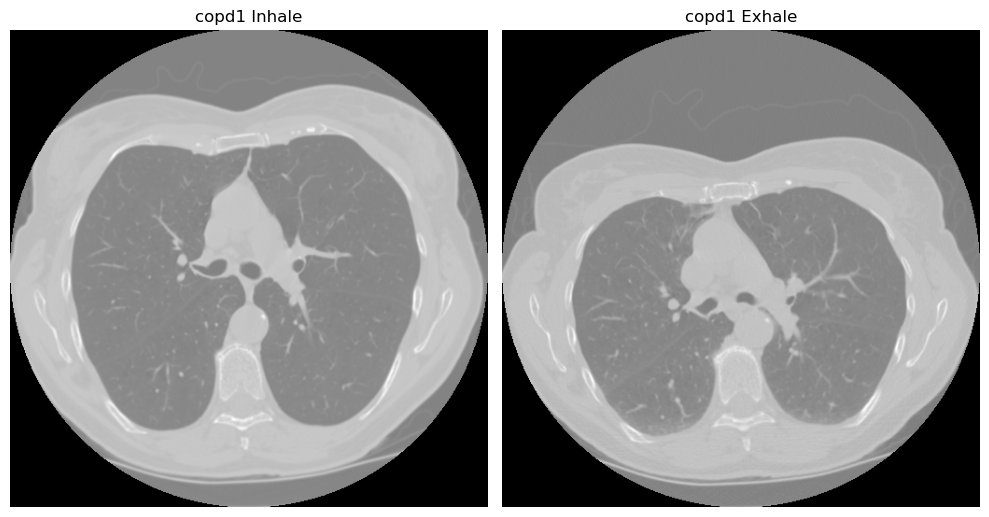

Processing copd2
Information: Size: [512, 512, 102], Spacing: [0.645, 0.645, 2.5], Displacement: Mean - 21.77 Std - 6.46
[b'ObjectType = Image\n', b'NDims = 3\n', b'DimSize = 512 512 102\n', b'ElementSpacing = 1 1 1\n', b'Offset = 0 0 0\n', b'TransformMatrix = 1 0 0 0 1 0 0 0 1\n', b'ElementType = MET_SHORT\n', b'BinaryData = True\n', b'BinaryDataByteOrderMSB = False\n', b'ElementDataFile = /Users/sumeetdash/MAIA/Semester_3/CODES/MIRA/Final_Project_MIRA/MIRA-COPDgene/data/copd2/copd2_iBHCT.img\n']
[b'ObjectType = Image\n', b'NDims = 3\n', b'DimSize = 512 512 102\n', b'ElementSpacing = 1 1 1\n', b'Offset = 0 0 0\n', b'TransformMatrix = 1 0 0 0 1 0 0 0 1\n', b'ElementType = MET_SHORT\n', b'BinaryData = True\n', b'BinaryDataByteOrderMSB = False\n', b'ElementDataFile = /Users/sumeetdash/MAIA/Semester_3/CODES/MIRA/Final_Project_MIRA/MIRA-COPDgene/data/copd2/copd2_eBHCT.img\n']


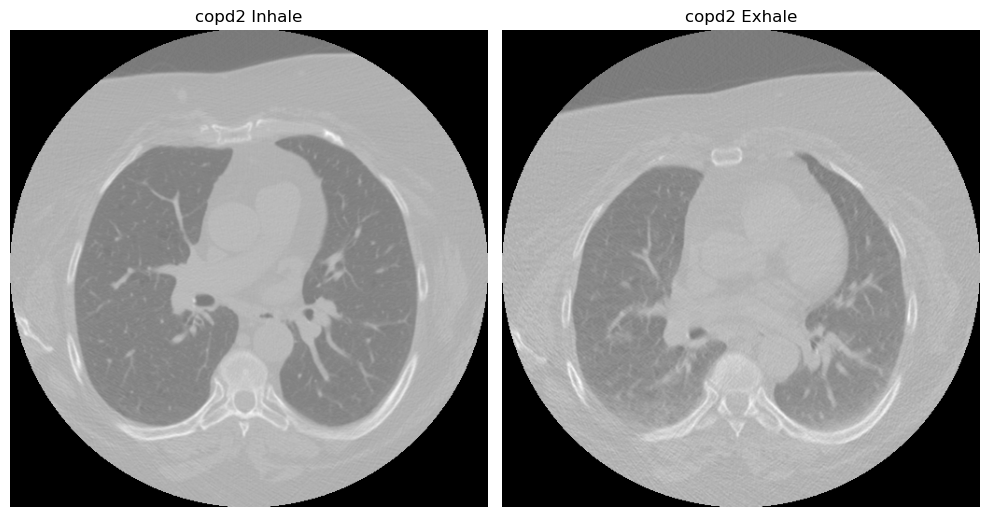

Processing copd3
Information: Size: [512, 512, 126], Spacing: [0.652, 0.652, 2.5], Displacement: Mean - 12.29 Std - 6.39
[b'ObjectType = Image\n', b'NDims = 3\n', b'DimSize = 512 512 126\n', b'ElementSpacing = 1 1 1\n', b'Offset = 0 0 0\n', b'TransformMatrix = 1 0 0 0 1 0 0 0 1\n', b'ElementType = MET_SHORT\n', b'BinaryData = True\n', b'BinaryDataByteOrderMSB = False\n', b'ElementDataFile = /Users/sumeetdash/MAIA/Semester_3/CODES/MIRA/Final_Project_MIRA/MIRA-COPDgene/data/copd3/copd3_iBHCT.img\n']
[b'ObjectType = Image\n', b'NDims = 3\n', b'DimSize = 512 512 126\n', b'ElementSpacing = 1 1 1\n', b'Offset = 0 0 0\n', b'TransformMatrix = 1 0 0 0 1 0 0 0 1\n', b'ElementType = MET_SHORT\n', b'BinaryData = True\n', b'BinaryDataByteOrderMSB = False\n', b'ElementDataFile = /Users/sumeetdash/MAIA/Semester_3/CODES/MIRA/Final_Project_MIRA/MIRA-COPDgene/data/copd3/copd3_eBHCT.img\n']


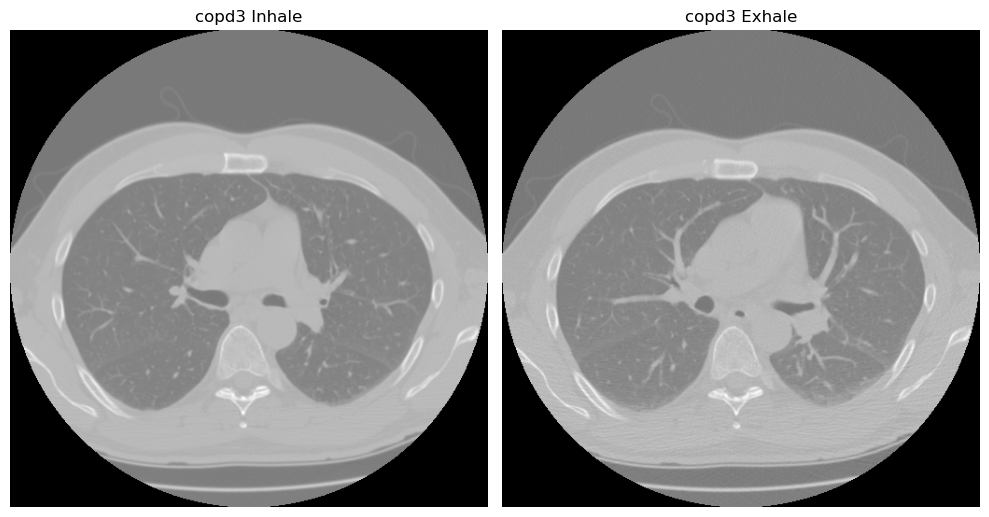

Processing copd4
Information: Size: [512, 512, 126], Spacing: [0.59, 0.59, 2.5], Displacement: Mean - 30.9 Std - 13.49
[b'ObjectType = Image\n', b'NDims = 3\n', b'DimSize = 512 512 126\n', b'ElementSpacing = 1 1 1\n', b'Offset = 0 0 0\n', b'TransformMatrix = 1 0 0 0 1 0 0 0 1\n', b'ElementType = MET_SHORT\n', b'BinaryData = True\n', b'BinaryDataByteOrderMSB = False\n', b'ElementDataFile = /Users/sumeetdash/MAIA/Semester_3/CODES/MIRA/Final_Project_MIRA/MIRA-COPDgene/data/copd4/copd4_iBHCT.img\n']
[b'ObjectType = Image\n', b'NDims = 3\n', b'DimSize = 512 512 126\n', b'ElementSpacing = 1 1 1\n', b'Offset = 0 0 0\n', b'TransformMatrix = 1 0 0 0 1 0 0 0 1\n', b'ElementType = MET_SHORT\n', b'BinaryData = True\n', b'BinaryDataByteOrderMSB = False\n', b'ElementDataFile = /Users/sumeetdash/MAIA/Semester_3/CODES/MIRA/Final_Project_MIRA/MIRA-COPDgene/data/copd4/copd4_eBHCT.img\n']


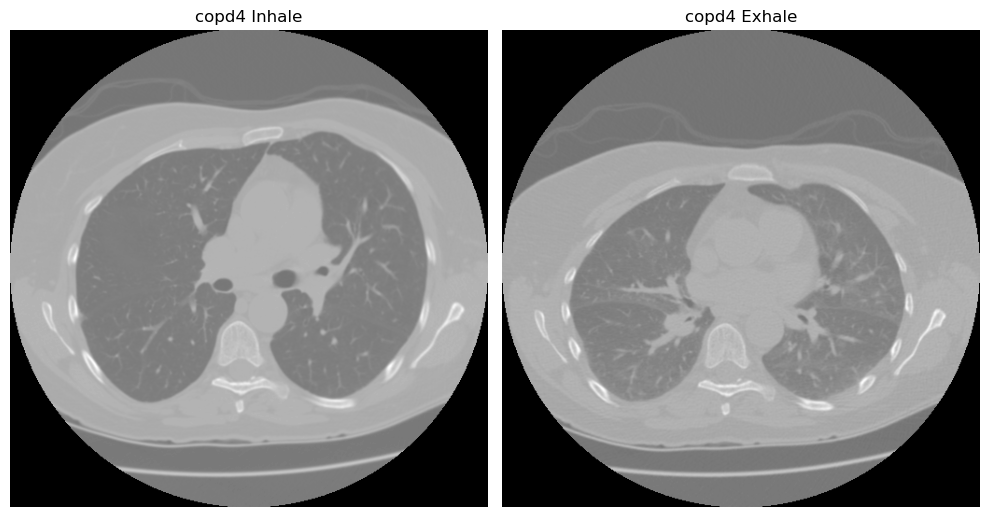

In [13]:
for key, value in dataset_info.items():
    print(f"Processing {key}")
    
    ## Read the images
    inhale_image_path = os.path.join(DATA_PATH, key, f'{key}_iBHCT.img')
    exhale_image_path = os.path.join(DATA_PATH, key, f'{key}_eBHCT.img')
    
    ## Read the metadata
    size = value["size"]
    spacing = value["spacing"]
    disp_mean = value["disp_mean"]
    disp_std = value["disp_std"]
    print(f"Information: Size: {size}, Spacing: {spacing}, Displacement: Mean - {disp_mean} Std - {disp_std}")
    
    # Read the image using both big and little endian
    inhale_image = read_raw(
        binary_file_name=inhale_image_path,
        image_size=size,
        sitk_pixel_type=sitk.sitkInt16,
    )
    exhale_image = read_raw(
        binary_file_name=exhale_image_path,
        image_size=size,
        sitk_pixel_type=sitk.sitkInt16,
    )

    ## Export the images to nii.gz
    inhale_export_path = inhale_image_path.replace(".img", ".nii.gz")
    exhale_export_path = exhale_image_path.replace(".img", ".nii.gz")
    sitk.WriteImage(inhale_image, inhale_export_path)
    sitk.WriteImage(exhale_image, exhale_export_path)
    
    ## Plot the images
    plot_images_sitk([inhale_export_path, exhale_export_path], titles=[f"{key} Inhale", f"{key} Exhale"], cols=2, slice_idx=50, fig_size=(10, 10))

## Raw Displacement

In [18]:
for key, value in dataset_info.items():
    print(f"Processing {key}")
    
    ## Read the metadata
    size = value["size"]
    spacing = value["spacing"]
    disp_mean = value["disp_mean"]
    disp_std = value["disp_std"]
    print(f"Information: Size: {size}, Spacing: {spacing}, Displacement: Mean - {disp_mean} Std - {disp_std}")
    
    inhale_landmarks_path = f"./data/{key}/{key}_300_iBH_xyz_r1.txt"
    exhale_landmarks_path = f"./data/{key}/{key}_300_eBH_xyz_r1.txt"
    landmarks_inhale = np.loadtxt(inhale_landmarks_path, skiprows=2)
    landmarks_exhale = np.loadtxt(exhale_landmarks_path)
    
    print(f"Landmarks: Inhale - {landmarks_inhale.shape}, Exhale - {landmarks_exhale.shape}")

    tre_mean, tre_std = target_registration_error(landmarks_inhale, landmarks_exhale, spacing)
    print(f"Mean T.R.E.: {tre_mean:.2f} mm")
    print(f"Std. Dev. T.R.E.: {tre_std:.2f} mm")
    print("-" * 50)

Processing copd1
Information: Size: [512, 512, 121], Spacing: [0.625, 0.625, 2.5], Displacement: Mean - 25.9 Std - 11.57
Landmarks: Inhale - (300, 3), Exhale - (300, 3)
Mean T.R.E.: 26.33 mm
Std. Dev. T.R.E.: 11.42 mm
--------------------------------------------------
Processing copd2
Information: Size: [512, 512, 102], Spacing: [0.645, 0.645, 2.5], Displacement: Mean - 21.77 Std - 6.46
Landmarks: Inhale - (300, 3), Exhale - (300, 3)
Mean T.R.E.: 21.79 mm
Std. Dev. T.R.E.: 6.46 mm
--------------------------------------------------
Processing copd3
Information: Size: [512, 512, 126], Spacing: [0.652, 0.652, 2.5], Displacement: Mean - 12.29 Std - 6.39
Landmarks: Inhale - (300, 3), Exhale - (300, 3)
Mean T.R.E.: 12.64 mm
Std. Dev. T.R.E.: 6.38 mm
--------------------------------------------------
Processing copd4
Information: Size: [512, 512, 126], Spacing: [0.59, 0.59, 2.5], Displacement: Mean - 30.9 Std - 13.49
Landmarks: Inhale - (300, 3), Exhale - (300, 3)
Mean T.R.E.: 29.58 mm
Std. D

## Elastix

### Without Mask

In [61]:
# Initialize the wrapper
elastix_transformix = ElastixTransformix(verbose=True, elastix_path=ELASTIX_PATH)

result_path = 'txt_results'
os.makedirs(result_path, exist_ok=True)

for key, value in dataset_info.items():
    if '1' not in key:
        continue
    print(f"Processing {key}")
    
    ## Open the file to write the results
    txt_file = open(f"{result_path}/{key}.txt", "w")
    
    ## Read the images
    inhale_image = os.path.join(DATA_PATH, key, f'{key}_iBHCT.nii.gz')
    exhale_image = os.path.join(DATA_PATH, key, f'{key}_eBHCT.nii.gz')
    
    # Paths
    parameter_files = [Path(f'{PARAMETER_PATH}/exps/Par0056rigid.txt'), Path(f'{PARAMETER_PATH}/exps/Par0016.multibsplines.lung.sliding_modified.txt')]

    # Run Elastix
    # elastix registers a moving image to a fixed image.
    transformation_file = elastix_transformix.run_elastix(
        fix_img_path=inhale_image,
        mov_img_path=exhale_image,
        res_path=RESULT_PATH,
        parameters_paths=parameter_files
    )

    # Run Transformix (for points)
    inhale_points_file = Path(os.path.join(DATA_PATH, key, f'{key}_300_iBH_xyz_r1.txt'))
    elastix_transformix.run_transformix(
        mov_img_path=inhale_points_file,
        res_path=RESULT_PATH,
        transformation_path=transformation_file,
        points=True
    )
    
    exhale_points_file = Path(os.path.join(DATA_PATH, key, f'{key}_300_eBH_xyz_r1.txt'))
    transformed_points_file = Path(os.path.join(RESULT_PATH, f'{key}_300_iBH_xyz_r1_points.txt'))

    inhale_points, transformed_inhale_points = parse_transformed_points(transformed_points_file)
    exhale_points = np.loadtxt(exhale_points_file)
    
    print('=' * 50 + 'Final Results' + '=' * 50)
    spacing = value["spacing"]
    mean_tre, std_tre = value["disp_mean"], value["disp_std"]
    tre_mean, tre_std = target_registration_error(exhale_points, transformed_inhale_points, spacing)
    
    txt_file.write(f"Original T.R.E.: Mean - {mean_tre:.2f} mm, Std. Dev. - {std_tre:.2f} mm \n")
    txt_file.write(f"Registed T.R.E.: Mean - {tre_mean:.2f} mm, Std. Dev. - {tre_std:.2f} mm")
    
    print("Original T.R.E.: ", f"Mean - {mean_tre:.2f} mm", f"Std. Dev. - {std_tre:.2f} mm")
    print(f"Registed T.R.E.: ", f"Mean - {tre_mean:.2f} mm", f"Std. Dev. - {tre_std:.2f} mm")
    
    txt_file.close()

Processing copd1
Running command: /Users/huytrq/Workspace/UdG/MIRA/elastix/elastix -out /Users/huytrq/Workspace/UdG/MIRA/Final/LungRegistration/results -f /Users/huytrq/Workspace/UdG/MIRA/Final/LungRegistration/data/copd1/copd1_iBHCT.nii.gz -m /Users/huytrq/Workspace/UdG/MIRA/Final/LungRegistration/data/copd1/copd1_eBHCT.nii.gz -p /Users/huytrq/Workspace/UdG/MIRA/Final/ElastixModelZoo/exps/Par0056rigid.txt -p /Users/huytrq/Workspace/UdG/MIRA/Final/ElastixModelZoo/exps/Par0016.multibsplines.lung.sliding_modified.txt

elastix is started at Fri Dec 20 01:32:24 2024.

which elastix:   /Users/huytrq/Workspace/UdG/MIRA/elastix/elastix
elastix runs at: huytrqm.local
  macOS 15.2 (x64), 24C101
  with 16384 MB memory, and 8 cores @ 2400 MHz.
-------------------------------------------------------------------------

Running elastix with parameter file 0: "/Users/huytrq/Workspace/UdG/MIRA/Final/ElastixModelZoo/exps/Par0056rigid.txt".

Current time: Fri Dec 20 01:32:24 2024.
Reading the elastix pa

### With Mask

In [67]:
from lungmask import LMInferer
import SimpleITK as sitk

inferer = LMInferer(modelname="R231")


lungmask 2024-12-20 03:42:35 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


In [69]:
input_image_path = '/Users/huytrq/Workspace/UdG/MIRA/Final/LungRegistration/data/copd1/copd1_iBHCT_gantry_removed.nii.gz'
input_image_ = nib.load(input_image_path)
input_image = input_image_.get_fdata()
segmentation = inferer.apply(input_image)  # default model is U-net(R231)
segmentation_export_path = '/Users/huytrq/Workspace/UdG/MIRA/Final/LungRegistration/data/copd1/copd1_iBHCT_segmentation_dl.nii.gz'
segmentation = nib.Nifti1Image(segmentation, input_image_.affine)
nib.save(segmentation, segmentation_export_path)

 98%|█████████▊| 25/25.6 [00:14<00:00,  1.83it/s]/Users/huytrq/miniconda3/envs/gpu/lib/python3.11/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
102%|██████████| 26/25.6 [00:15<00:00,  1.73it/s]

lungmask 2024-12-20 03:43:32 Postprocessing



100%|██████████| 102/102 [00:01<00:00, 52.44it/s]


Processing copd1
Information: Size: [512, 512, 121], Spacing: [0.625, 0.625, 2.5], Displacement: Mean - 25.9 Std - 11.57


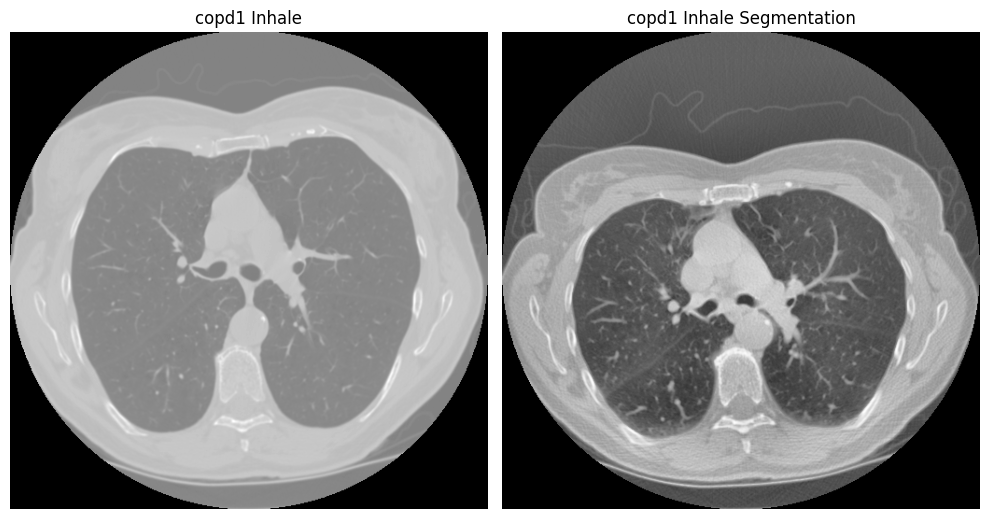

Processing copd2
Information: Size: [512, 512, 102], Spacing: [0.645, 0.645, 2.5], Displacement: Mean - 21.77 Std - 6.46


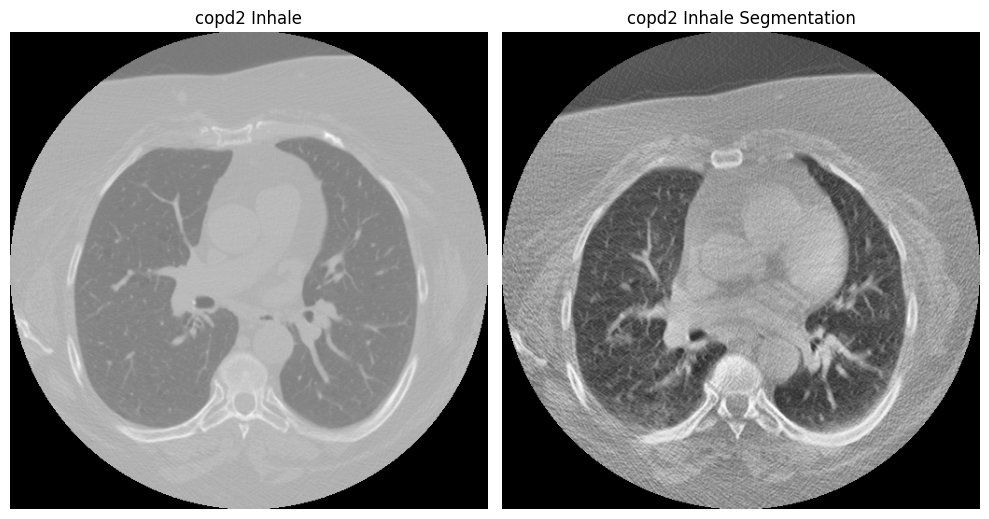

Processing copd3
Information: Size: [512, 512, 126], Spacing: [0.652, 0.652, 2.5], Displacement: Mean - 12.29 Std - 6.39


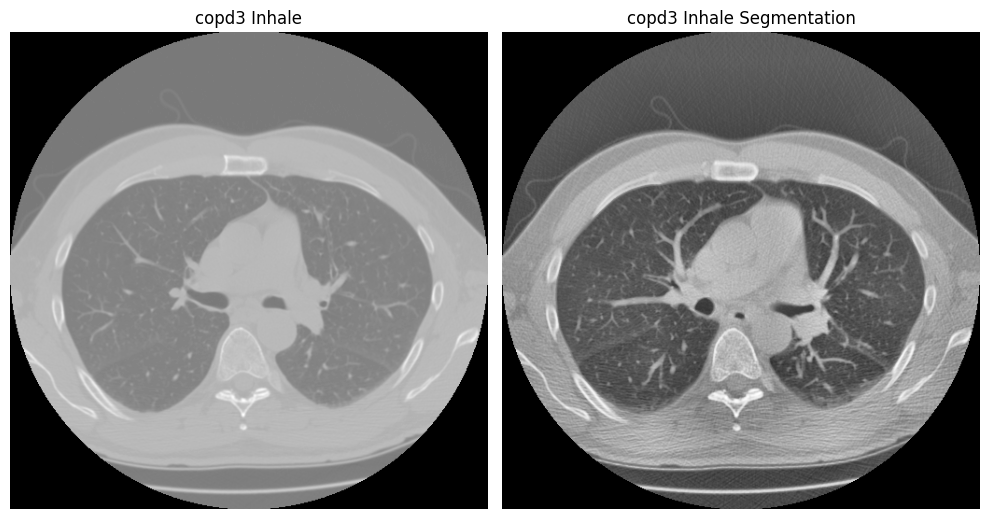

Processing copd4
Information: Size: [512, 512, 126], Spacing: [0.59, 0.59, 2.5], Displacement: Mean - 30.9 Std - 13.49


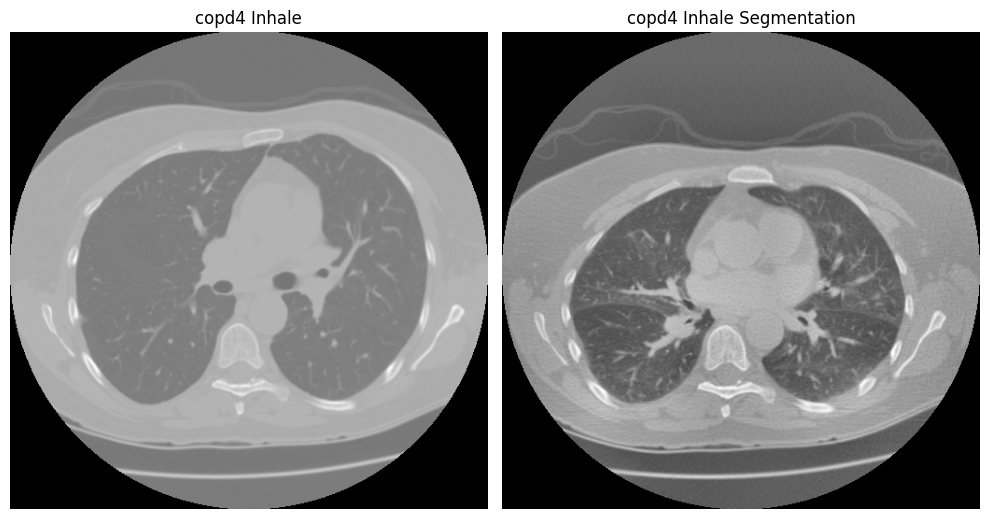

In [ ]:
# Segmentation
for key, value in dataset_info.items():
    print(f"Processing {key}")
    
    ## Read the images
    inhale_image_path = os.path.join(DATA_PATH, key, f'{key}_iBHCT.nii.gz')
    exhale_image_path = os.path.join(DATA_PATH, key, f'{key}_eBHCT.nii.gz')
    
    ## Read the metadata
    size = value["size"]
    spacing = value["spacing"]
    disp_mean = value["disp_mean"]
    disp_std = value["disp_std"]
    print(f"Information: Size: {size}, Spacing: {spacing}, Displacement: Mean - {disp_mean} Std - {disp_std}")
    
    input_image_ = nib.load(exhale_image_path)
    input_image = input_image_.get_fdata()
    input_image_n = normalize_image(input_image)
    input_image = apply_clahe(input_image_n)
    # segmentation = inferer.apply(input_image)  # default model is U-net(R231)
    
    ## Export the images to nii.gz
    segmentation_export_path = exhale_image_path.replace(".nii.gz", "_normalized.nii.gz")
    normalized = nib.Nifti1Image(input_image, input_image_.affine)
    nib.save(normalized, segmentation_export_path)
    
    # ## Plot the images
    plot_images([inhale_image_path, segmentation_export_path], titles=[f"{key} Inhale", f"{key} Inhale Segmentation"], cols=2, slice_idx=50, fig_size=(10, 10))
    
   
    

In [ ]:

segmentation_export_path = inhale_image_path.replace(".nii.gz", "_segmentation.nii.gz")
segmentation = nib.Nifti1Image(segmentation, input_image.affine)
nib.save(segmentation, segmentation_export_path)

## Plot the images
plot_images([inhale_image_path, segmentation_export_path], titles=[f"{key} Inhale", f"{key} Inhale Segmentation"], cols=2, slice_idx=50, fig_size=(10, 10))


# SIMET


In [19]:
import nrrd
def load_nrrd_to_numpy_without_header(nrrd_file_path):
    """
    Loads an NRRD file as a NumPy array, even if no separate header file exists.

    Parameters
    ----------
    nrrd_file_path : str
        Path to the NRRD file.

    Returns
    -------
    np.ndarray
        NumPy array representation of the NRRD data.
    """
    try:
        # Load the NRRD file
        data, _ = nrrd.read(nrrd_file_path)
        return data
    except Exception as e:
        print(f"Error reading NRRD file: {e}")
        return None



In [57]:
# Example usage
nrrd_file_path = "/Users/huytrq/Workspace/UdG/MIRA/Final/LungRegistration/data/copd1/copd1_eBHCT_segmentation.nrrd"  # Replace with the actual path to your NRRD file
data = load_nrrd_to_numpy_without_header(nrrd_file_path)

if data is not None:
    print("Data shape:", data.shape)
else:
    print("Failed to load the NRRD file.")

Data shape: (3, 513, 512, 123)


In [58]:
nii_file_path = "./data/copd1/copd1_eBHCT_normalized.nii.gz"
image = nib.load(nii_file_path)
affine = image.affine

# Export mask
data = data[:,1:,1:,1:-1]
lung = data[1,:,:,:]
lung = lung.astype(np.uint8)

mask = nib.Nifti1Image(lung, affine)
nib.save(mask, nii_file_path.replace(".nii.gz", "_mask.nii.gz"))

In [60]:
# Initialize the wrapper
elastix_transformix = ElastixTransformix(verbose=True, elastix_path=ELASTIX_PATH)

result_path = 'txt_results'
os.makedirs(result_path, exist_ok=True)

for key, value in dataset_info.items():
    if '1' not in key:
        continue
    print(f"Processing {key}")
    
    ## Open the file to write the results
    txt_file = open(f"{result_path}/{key}.txt", "w")
    
    ## Read the images
    inhale_image = os.path.join(DATA_PATH, key, f'{key}_iBHCT.nii.gz')
    exhale_image = os.path.join(DATA_PATH, key, f'{key}_eBHCT.nii.gz')
    inhale_mask = os.path.join(DATA_PATH, key, f'{key}_iBHCT_mask.nii.gz')
    exhale_mask = os.path.join(DATA_PATH, key, f'{key}_eBHCT_mask.nii.gz')
    
    # Paths
    parameter_files = [Path(f'{PARAMETER_PATH}/exps/Par0056rigid.txt'), Path(f'{PARAMETER_PATH}/exps/Par0016.multibsplines.lung.sliding_modified.txt')]

    # Run Elastix
    # elastix registers a moving image to a fixed image.
    transformation_file = elastix_transformix.run_elastix(
        fix_img_path=inhale_image,
        mov_img_path=exhale_image,
        res_path=RESULT_PATH,
        parameters_paths=parameter_files,
        fix_mask_path = inhale_mask,
        mov_mask_path = exhale_mask
    )

    # Run Transformix (for points)
    inhale_points_file = Path(os.path.join(DATA_PATH, key, f'{key}_300_iBH_xyz_r1.txt'))
    elastix_transformix.run_transformix(
        mov_img_path=inhale_points_file,
        res_path=RESULT_PATH,
        transformation_path=transformation_file,
        points=True
    )
    
    exhale_points_file = Path(os.path.join(DATA_PATH, key, f'{key}_300_eBH_xyz_r1.txt'))
    transformed_points_file = Path(os.path.join(RESULT_PATH, f'{key}_300_iBH_xyz_r1_points.txt'))

    inhale_points, transformed_inhale_points = parse_transformed_points(transformed_points_file)
    exhale_points = np.loadtxt(exhale_points_file)
    
    print('=' * 50 + 'Final Results' + '=' * 50)
    spacing = value["spacing"]
    mean_tre, std_tre = value["disp_mean"], value["disp_std"]
    tre_mean, tre_std = target_registration_error(exhale_points, transformed_inhale_points, spacing)
    
    txt_file.write(f"Original T.R.E.: Mean - {mean_tre:.2f} mm, Std. Dev. - {std_tre:.2f} mm \n")
    txt_file.write(f"Registed T.R.E.: Mean - {tre_mean:.2f} mm, Std. Dev. - {tre_std:.2f} mm")
    
    print("Original T.R.E.: ", f"Mean - {mean_tre:.2f} mm", f"Std. Dev. - {std_tre:.2f} mm")
    print(f"Registed T.R.E.: ", f"Mean - {tre_mean:.2f} mm", f"Std. Dev. - {tre_std:.2f} mm")
    
    txt_file.close()

Processing copd1
Running command: /Users/huytrq/Workspace/UdG/MIRA/elastix/elastix -out /Users/huytrq/Workspace/UdG/MIRA/Final/LungRegistration/results -f /Users/huytrq/Workspace/UdG/MIRA/Final/LungRegistration/data/copd1/copd1_iBHCT.nii.gz -m /Users/huytrq/Workspace/UdG/MIRA/Final/LungRegistration/data/copd1/copd1_eBHCT.nii.gz -fMask /Users/huytrq/Workspace/UdG/MIRA/Final/LungRegistration/data/copd1/copd1_iBHCT_mask.nii.gz -mMask /Users/huytrq/Workspace/UdG/MIRA/Final/LungRegistration/data/copd1/copd1_eBHCT_mask.nii.gz -p /Users/huytrq/Workspace/UdG/MIRA/Final/ElastixModelZoo/exps/Par0056rigid.txt -p /Users/huytrq/Workspace/UdG/MIRA/Final/ElastixModelZoo/exps/Par0016.multibsplines.lung.sliding_modified.txt

elastix is started at Fri Dec 20 01:28:37 2024.

which elastix:   /Users/huytrq/Workspace/UdG/MIRA/elastix/elastix
elastix runs at: huytrqm.local
  macOS 15.2 (x64), 24C101
  with 16384 MB memory, and 8 cores @ 2400 MHz.
-------------------------------------------------------------

In [44]:
image_file =("/Users/huytrq/Workspace/UdG/MIRA/Final/LungRegistration/data/copd1/copd1_eBHCT.nii.gz")
image = nib.load(image_file)
image_data = image.get_fdata()

# removed, mask = remove_gantry(image_data, visualize=True)

# plt.imshow(removed[:,:,50], cmap='gray')


In [45]:
def segment_kmeans(image_array, K=3):
    pixels = image_array.flatten().reshape(-1, 1).astype(np.float32)
    _, labels, _ = cv2.kmeans(
        pixels,
        K,
        None,
        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2),
        10,
        cv2.KMEANS_RANDOM_CENTERS,
    )
    segmented = labels.reshape(image_array.shape)
    return segmented

def fill_chest_cavity(image):
        """
        Fill the chest cavity to obtain the final gantry mask.

        Parameters
        ----------
        image : ndarray
            Input binary image.

        Returns
        -------
        ndarray
            Chest cavity filled binary mask.
        """
        image = image.astype(np.uint8)
        filled_image = np.zeros_like(image)
        for i in range(image.shape[2]):  # Iterate over slices along z-axis
            slice_ = image[:, :, i]
            contours, _ = cv2.findContours(slice_, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            mask = np.zeros(slice_.shape, dtype="uint8")
            area = [cv2.contourArea(contour) for contour in contours]
            if len(area) == 0:
                continue
            index_contour = area.index(max(area))
            cv2.drawContours(mask, contours, index_contour, 255, -1)
            kernel = np.ones((7, 7), np.uint8)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
            filled_image[:, :, i] = mask
        return filled_image / 255

In [58]:
seg = segment_kmeans(image_data, K=3)   

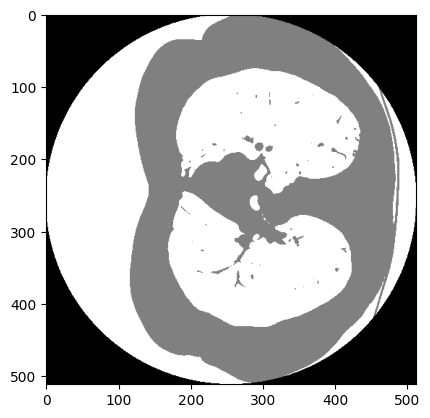

In [59]:
plt.imshow(seg[:,:,50], cmap='gray')

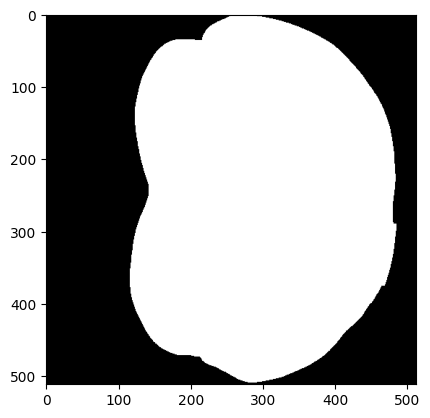

In [60]:
gantry_mask = seg * (seg == 1)
gantry_mask = fill_chest_cavity(gantry_mask)
gantry_mask = gantry_mask.astype(np.uint8)
plt.imshow(gantry_mask[:,:,50], cmap='gray')

In [61]:
gantry_removed = np.zeros_like(image_data)
gantry_removed[gantry_mask == 1] = image_data[gantry_mask == 1]

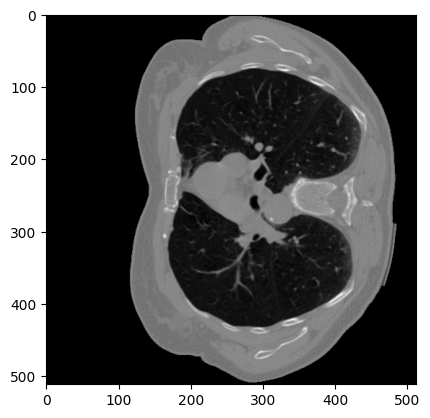

In [62]:
plt.imshow(gantry_removed[:,:,50], cmap='gray')

In [63]:
gantry_removed = normalize_image(gantry_removed)
gantry_removed = apply_clahe(gantry_removed)





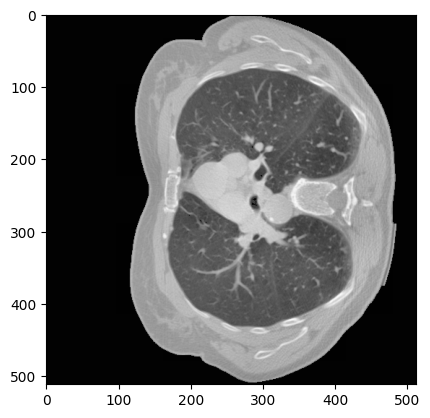

In [64]:
plt.imshow(gantry_removed[:,:,50], cmap='gray')


In [65]:
gantry_removed = nib.Nifti1Image(gantry_removed, image.affine)
nib.save(gantry_removed, image_file.replace(".nii.gz", "_gantry_removed.nii.gz"))